# Proyek Klasifikasi Gambar: Klasifikasi Tumpahan Minyak Di Laut
- **Nama:** Gregorius Dwika Kuncahyo Dewaji
- **Email:** gregoriusdwika@gmail.com


## Impor Library

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gregoriusdwika","key":"97541f51a52aeee9b53bbfacc37589fb"}'}

In [ ]:
!kaggle datasets download -d vighneshanand/oil-spill-dataset-binary-image-classification
!unzip oil-spill-dataset-binary-image-classification

Dataset URL: https://www.kaggle.com/datasets/vighneshanand/oil-spill-dataset-binary-image-classification
License(s): unknown
100% 790M/792M [00:11<00:00, 75.1MB/s]
100% 792M/792M [00:11<00:00, 71.0MB/s]
Archive:  oil-spill-dataset-binary-image-classification.zip
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00001.jpg  
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00002.jpg  
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00003.jpg  
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00004.jpg  
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00005.jpg  
  inflating: final dataset used for oil spill/dataset-final/dataset/Validation/Non Oil Spill/AUG_Non_oil_spill00006.jpg  
  inf

### Gabungkan Data Train dan Data Test ke Direktori yang Sama

In [ ]:
#old_folder_path = "/content/Dataset/test/ships"
#new_folder_path = "/content/Dataset/test/ship"

# Ubah nama folder
#!mv $old_folder_path $new_folder_path

In [ ]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "/content/final dataset used for oil spill/dataset-final/dataset/train"
test_dir = "/content/final dataset used for oil spill/dataset-final/dataset/test"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/final dataset used for oil spill/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)


# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)


### Plot gambar sampel untuk semua kelas

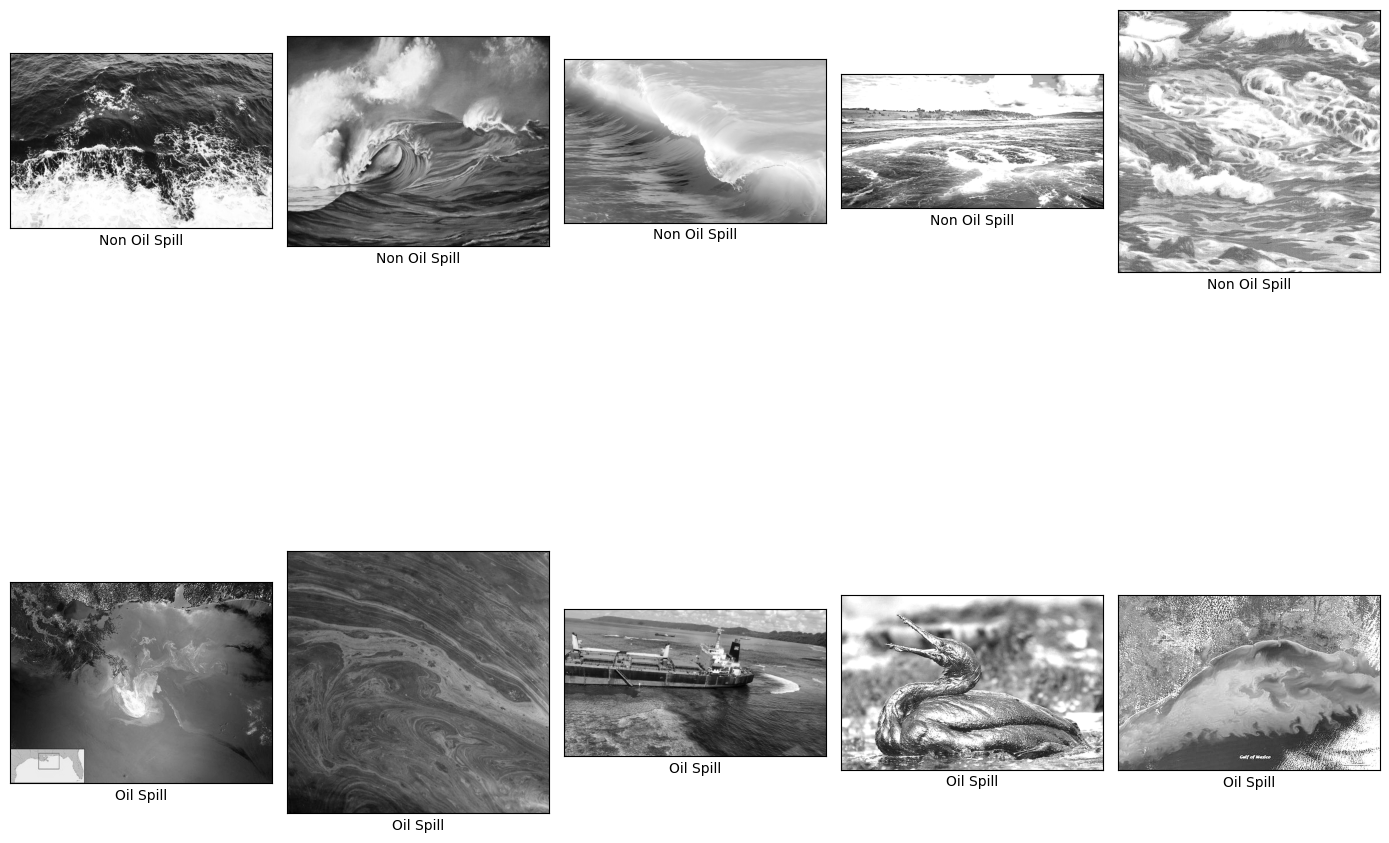

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
oil_image = {}

# Tentukan path sumber train
path = "/content/final dataset used for oil spill"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
   oil_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "/content/final dataset used for oil spill/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(oil_image.keys()), 5, figsize=(14, 14))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(oil_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Plot distribusi gambar di seluruh kelas

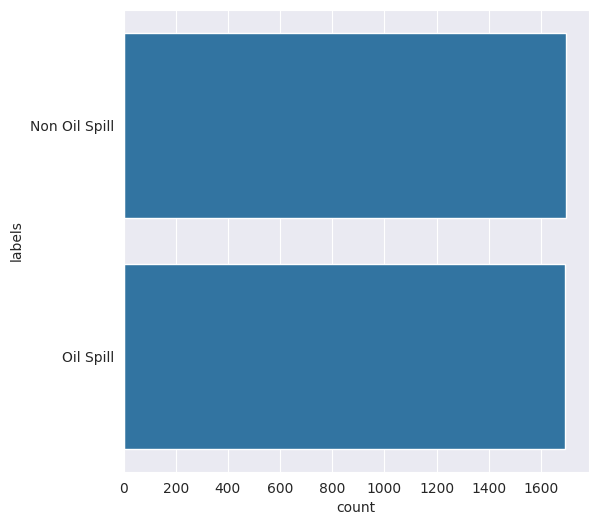

In [ ]:
# Define source path
oil_path = "/content/final dataset used for oil spill/dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(oil_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data Split

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/final dataset used for oil spill/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Non Oil Spill    1697
Oil Spill        1692
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 2711
test size 678


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels       
test   Non Oil Spill     339
       Oil Spill         339
train  Non Oil Spill    1358
       Oil Spill        1353
dtype: int64 


                                                   path         labels    set
250   /content/final dataset used for oil spill/data...      Oil Spill  train
864   /content/final dataset used for oil spill/data...      Oil Spill  train
181   /content/final dataset used for oil spill/data...      Oil Spill  train
2892  /content/final dataset used for oil spill/data...  Non Oil Spill   test
2201  /content/final dataset used for oil spill/data...  Non Oil Spill  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/final dataset used for oil spill/dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2170 images belonging to 2 classes.
Found 541 images belonging to 2 classes.
Found 678 images belonging to 2 classes.


In [ ]:
train_oil_spill = os.path.join(TRAIN_DIR + '/Oil Spill')
test_oil_spill = os.path.join(TEST_DIR + '/Oil Spill')
train_non_oil_spill = os.path.join(TRAIN_DIR + '/Non Oil Spill')
test_non_oil_spill = os.path.join(TEST_DIR + '/Non Oil Spill')

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_4 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                      

In [ ]:
count_non_oil_spill, count_oil_spill = len(os.listdir(train_non_oil_spill)), len(os.listdir(train_oil_spill))
weight_0 = (1 / count_non_oil_spill) * (count_non_oil_spill + count_oil_spill) / 2.0
weight_1 = (1 / count_oil_spill) * (count_oil_spill + count_non_oil_spill ) / 2.0


class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/30
68/68 [==============================] - 22s 282ms/step - loss: 2.1886 - accuracy: 0.5747 - val_loss: 0.6147 - val_accuracy: 0.6876
Epoch 2/30
68/68 [==============================] - 19s 288ms/step - loss: 1.1367 - accuracy: 0.6479 - val_loss: 0.5952 - val_accuracy: 0.7135
Epoch 3/30
68/68 [==============================] - 19s 279ms/step - loss: 0.7761 - accuracy: 0.7124 - val_loss: 0.5341 - val_accuracy: 0.7227
Epoch 4/30
68/68 [==============================] - 20s 294ms/step - loss: 0.5317 - accuracy: 0.7917 - val_loss: 0.4973 - val_accuracy: 0.7412
Epoch 5/30
68/68 [==============================] - 19s 277ms/step - loss: 0.4273 - accuracy: 0.8304 - val_loss: 0.3592 - val_accuracy: 0.8281
Epoch 6/30
68/68 [==============================] - 20s 302ms/step - loss: 0.3159 - accuracy: 0.8788 - val_loss: 0.2892 - val_accuracy: 0.8595
Epoch 7/30
68/68 [==============================] - 20s 290ms/step - loss: 0.2

## Evaluasi dan Visualisasi

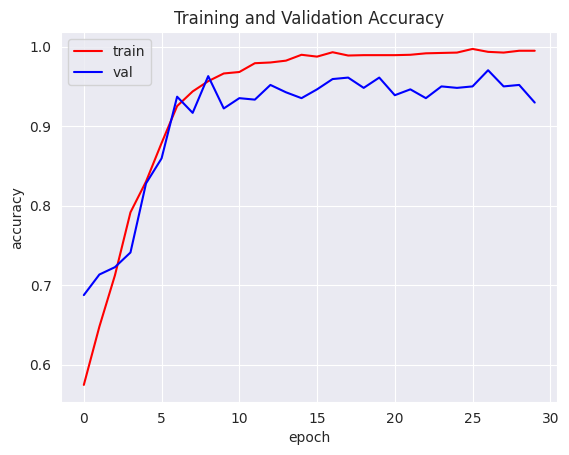

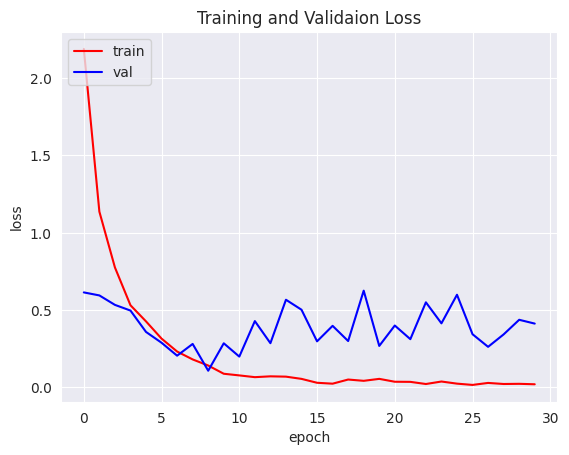

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



               precision    recall  f1-score   support

Non Oil Spill     0.9435    0.9853    0.9639       339
    Oil Spill     0.9846    0.9410    0.9623       339

     accuracy                         0.9631       678
    macro avg     0.9640    0.9631    0.9631       678
 weighted avg     0.9640    0.9631    0.9631       678



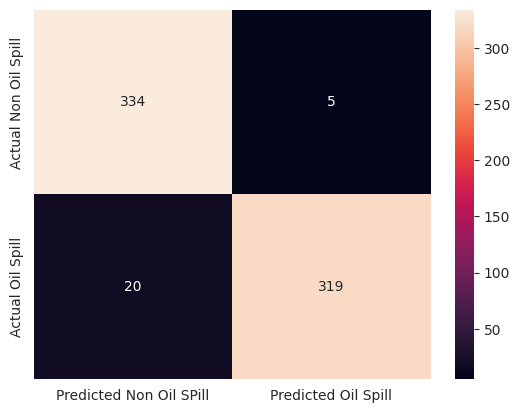

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Non Oil Spill", "Actual Oil Spill"],
columns=["Predicted Non Oil SPill", "Predicted Oil Spill"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Non Oil Spill','Oil Spill'], digits=4))

## Konversi Model

In [ ]:
model_1.save("model.pb")

In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 28.0 MB/s eta 0

In [ ]:
model_1.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-07-29 10:08:51.966822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 10:08:52.076459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 10:08:52.076544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 10:08:53.855746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model_1, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

5617260

In [ ]:
!pip freeze > requirements.txt